<a href="https://colab.research.google.com/github/ethngo7/pytorchfire/blob/main/examples/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install pytorchfire and dependencies

%pip install pytorchfire
%pip install requests
%pip install matplotlib
%pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [6]:
# @title Download the dataset

from google.colab import files
import requests

# @markdown If you want to upload your own data, set `upload_custom_data` to `True` and make sure to upload all the files listed in `file_list`.
# @markdown The format should be either `.npy` or `.npz`.
# @markdown If you want to use the demo dataset, set `upload_custom_data` to `False`.
upload_custom_data = False # @param {type:"boolean"}

file_list = [
    'initial_ignition',
    'p_den',
    'p_veg',
    'slope',
    'target',
    'wind_towards_direction',
    'wind_velocity',
]

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

if upload_custom_data:
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
else:
    remote_map_name = 'Bear_2020'

    for file in file_list:
        file_url = f'https://github.com/xiazeyu/PyTorchFire/raw/refs/heads/main/examples/{remote_map_name}/{file}.npz'
        filename = f'{file}.npz'
        download_file(file_url, filename)

        print(f"File downloaded and saved as {filename}")


In [85]:
# @title Load the dataset
import numpy as np
import os

def load_np_file(file_name):

    if os.path.exists(f'{file_name}.npy'):
        return np.load(f'{file_name}.npy')
    elif os.path.exists(f'{file_name}.npz'):
        ds = np.load(f'{file_name}.npz')
        if len(ds.files) == 1:
            return ds[ds.files[0]]
        else:
            raise ValueError(f"Multiple arrays found in {file_name}. Please provide a single array.")

p_veg = load_np_file('p_veg')
p_den = load_np_file('p_den')
wind_towards_direction = load_np_file('wind_towards_direction')
wind_velocity = load_np_file('wind_velocity')
slope = load_np_file('slope')
initial_ignition = load_np_file('initial_ignition')

a = 0.13324953615665436 # @param {type:"number"}
c_1 = 0.11270108073949814 # @param {type:"number"}
c_2 = 0.15624772012233734 # @param {type:"number"}
max_steps = 50 # @param {type:"integer"}
p_continue = 0.2814338207244873 # @param {type:"slider", min:0, max:1, step:0.05}
p_h = 0.3236876130104065 # @param {type:"slider", min:0, max:1, step:0.05}
wind_step_interval = 15 # @param {type:"integer"}


# a: evenness of spread (smaller is even spread)
# p_h: super low base probability means it will slow down and stop.
# p_continue: tied to p_h --> doesn't do much on its own
# max_steps: more steps --> more time to spread

In [86]:
# @title Run the simulation

from pytorchfire import WildfireModel
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

model = WildfireModel({
        'p_veg': torch.tensor(p_veg),
        'p_den': torch.tensor(p_den),
        'wind_towards_direction': torch.tensor(wind_towards_direction[0]),
        'wind_velocity': torch.tensor(wind_velocity[0]),
        'slope': torch.tensor(slope),
        'initial_ignition': torch.tensor(initial_ignition, dtype=torch.bool)
    }, {
        'a': torch.tensor(a),
        'p_h': torch.tensor(p_h),
        'p_continue': torch.tensor(p_continue),
        'c_1': torch.tensor(c_1),
        'c_2': torch.tensor(c_2),
    })

model.to(device)
model.eval()

affected_cell_count_outputs = []
affected_cell_count_targets = []

postfix = {}
output_list = []

with tqdm(total=max_steps) as progress_bar:
        with torch.no_grad():
            for steps in range(max_steps):
                postfix['steps'] = f'{steps + 1}/{max_steps}'

                if steps % wind_step_interval == 0:
                    model.wind_towards_direction = torch.tensor(
                        wind_towards_direction[steps // wind_step_interval], device=device)
                    model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                            device=device)

                model.compute()
                outputs = model.state[0] | model.state[1]

                postfix['burning'] = model.state[0].sum().detach().cpu().item()
                postfix['burned'] = model.state[1].sum().detach().cpu().item()

                output_list.append(outputs.cpu().detach().numpy())

                progress_bar.set_postfix(postfix)
                progress_bar.update(1)


Using device: cuda


100%|██████████| 50/50 [00:00<00:00, 68.86it/s, steps=50/50, burning=175, burned=3813]


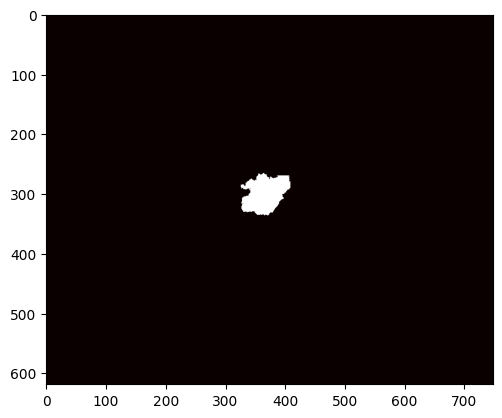

In [87]:
# @title Visualize the simulation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

im = ax.imshow(output_list[0], cmap='hot')

def update(frame):
    im.set_array(output_list[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(output_list), interval=100, blit=True
)

ani.save('prediction.gif', fps=10)
HTML(ani.to_jshtml())

![Animation](https://github.com/xiazeyu/PyTorchFire/blob/main/examples/prediction.gif?raw=1)